# Prediction Applications
1. Contains model accuracy experiments such as accuracy over time, observation, role and pitch zone
2. Contains downstream applications of the models such as player heatmaps, pitch control & distance covered

In order to run this notebook, you must store model results (predictions on testing data) in a ModelResults directory and load this file using the code below. The model results file can be generated using the ImputationModel/PlayerPositionImputation.ipynb notebook.

In [1]:
import numpy as np
import random
import pandas as pd
import scipy.stats
import mplsoccer as mpl
from mplsoccer import Pitch
from statsmodels.stats.weightstats import DescrStatsW
import os
os.chdir("..")
import UtilFunctions.pitch_control as pc
import UtilFunctions.plot_functions as pf
import UtilFunctions.util_functions as ut
import Experiments.experiment_plots as ep
import matplotlib.pyplot as plt

C:\Apps\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Apps\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Apps\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


## Load in results data from ML models
Get these results data by running the models in the ImputationModel folder, and storing results in dataframes (explained at the bottom of the PlayerPositionImputation notebook)

Data must be the same for each of the models for these experimental comparisons to work

In [2]:
#Load data in for final imputation model and set time to seconds
agent_imputer = pd.read_csv('ModelResults/sorted_results_ohe.csv')
agent_imputer_train = pd.read_csv('ModelResults/sorted_results_ohe_train.csv')
#agent_imputer = pd.read_csv('ModelResults/sorted_results_gnn_timeupdated_test.csv')
#agent_imputer_train = pd.read_csv('ModelResults/sorted_results_gnn_timeupdated_train.csv')
agent_imputer['event_time'] = agent_imputer['event_time'] / 1000
agent_imputer_train['event_time'] = agent_imputer_train['event_time'] / 1000

#Load in other machine learning model results
lstm_results = pd.read_csv('ModelResults/sorted_results_ohe_lstm.csv')
xgboost_results = pd.read_csv('ModelResults/xgboost_preds_time.csv')
gnn_results = pd.read_csv('ModelResults/sorted_results_ohe_gnn.csv')

#Load in naive baseline results
baseline1_results = pd.read_csv('ModelResults/baseline_1_results.csv')
baseline2_results = pd.read_csv('ModelResults/baseline_2_results.csv')
baseline3_results = pd.read_csv('ModelResults/baseline_3_results.csv')

#Include other features for xgboost results
xgboost_results['player_on_ball'] = agent_imputer['player_on_ball'].copy()
xgboost_results['time_since_seen'] = agent_imputer['player_on_ball'].copy()
xgboost_results.loc[xgboost_results['player_on_ball'] == True, 'dist'] = 0
xgboost_results['team_on_ball'] = agent_imputer['team_on_ball'].copy()
xgboost_results['position'] = agent_imputer['position'].copy()

# Model Accuracy Experiments

## Experiment 1 - Comparing Distance Error for Player Role

In [3]:
agent_imputer = agent_imputer.dropna(subset=['position'])
agent_imputer_train = agent_imputer_train.dropna(subset=['position'])
print("Unique positions: ", agent_imputer['position'].unique())

Unique positions:  ['GK' 'LWB' 'CB' 'RWB' 'CM' 'CAM' 'CF' 'CDM' 'LB' 'RB' 'LW' 'RW' 'RM' 'LM']


#### Get x and y error for train and test results

In [4]:
agent_imputer['x_dist'] = abs(agent_imputer['act_x'] - agent_imputer['pred_x'])
agent_imputer['y_dist'] = abs(agent_imputer['act_y'] - agent_imputer['pred_y'])
agent_imputer_train['x_dist'] = abs(agent_imputer_train['act_x'] - agent_imputer_train['pred_x'])
agent_imputer_train['y_dist'] = abs(agent_imputer_train['act_y'] - agent_imputer_train['pred_y'])

#### Optional: Convert positions to generic positions

In [5]:
agent_imputer = ut.convert_positions_to_generic_sloan(agent_imputer.copy())
agent_imputer_train = ut.convert_positions_to_generic_sloan(agent_imputer_train.copy())

#### Create grouped dataframes with mean errors for each role

In [6]:
agent_positions_count_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').size()
agent_positions_error_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').mean()
agent_positions_std_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').std()
agent_positions_count = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').size()
agent_positions_error = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').mean()
agent_positions_std = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').std()
position_errors_combined = pd.concat([agent_positions_error_train,agent_positions_error],axis=1)
position_errors_combined.columns = ['train_dist','train_x_dist','train_y_dist','test_dist','test_x_dist','test_y_dist']
position_errors_combined = position_errors_combined.dropna(subset=['test_dist'])
position_errors_combined

,train_dist,train_x_dist,train_y_dist,test_dist,test_x_dist,test_y_dist
position,,,,,,
Center Back,5.245032,3.263087,3.382614,5.669353,3.550383,3.645943
Center Midfielder,6.678175,4.008279,4.466514,7.215266,4.133873,5.051754
Goalkeeper,2.879722,2.275692,1.296351,2.608635,1.978177,1.260259
Striker,7.930338,4.196894,5.805691,8.713850,4.737684,6.214573
Wing Back,6.069590,4.277871,3.425760,7.300569,5.247864,4.055740
Winger,7.152863,4.599732,4.436391,7.845574,4.866462,5.057109


#### Optional: Get the average error for wide and central players

In [7]:
#print("Average X Error Wide: ", position_errors_combined.loc[['Wide Defender','Wide Midfielder','Wide Attacker'],'test_x_dist'].mean())
#print("Average X Error Central: ", position_errors_combined.loc[['Central Defender','Central Midfielder','Central Attacker'],'test_x_dist'].mean())
#print("Average Y Error Wide: ", position_errors_combined.loc[['Wide Defender','Wide Midfielder','Wide Attacker'],'test_y_dist'].mean())
#print("Average Y Error Central: ", position_errors_combined.loc[['Central Defender','Central Midfielder','Central Attacker'],'test_y_dist'].mean())

#### Calculate confidence intervals for error per position

In [8]:
samples_train = agent_imputer_train['position'].value_counts().sort_index()
samples_test = agent_imputer['position'].value_counts().sort_index()

#Optional if using all roles
#samples_train = samples_train.drop(['LF','RF'])
#agent_positions_std_train = agent_positions_std_train.drop(['LF','RF'])

agent_positions_std_train = ut.get_standard_errors_all_directions(agent_positions_std_train,samples_train)
agent_positions_std = ut.get_standard_errors_all_directions(agent_positions_std,samples_test)

#### Load Plot
Must checkout and install: https://github.com/garrettj403/SciencePlots

In [9]:
position_errors_combined.index = pd.Categorical(position_errors_combined.index, categories = ep.sorted_roles_sloan()[::-1])
position_errors_combined = position_errors_combined.sort_index()

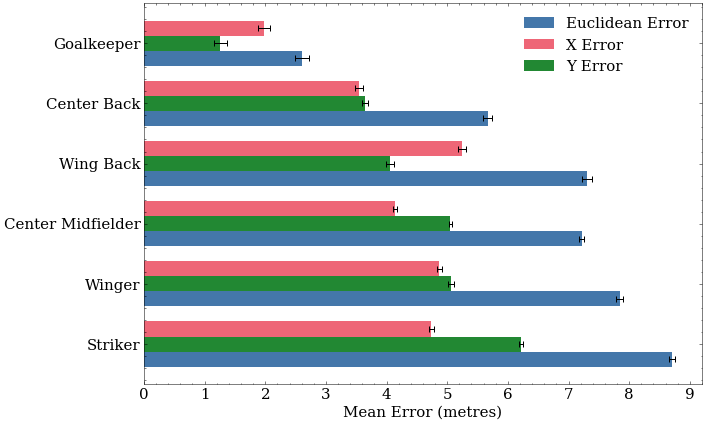

In [10]:
role_error_fig = ep.create_role_error_plot_test(position_errors_combined,agent_positions_std_train,agent_positions_std,agent_imputer)

## Experiment 2: Get error across time since observation
For up to 20 seconds, calculate error of the model when it's been a certain amount of time since the agent was last seen (e.g. between 1 and 2 seconds). Show how error changes over time since observation

In [11]:
#Calculates time since last and next seen and adds to dataframes
gnn_results = ut.get_time_since_seen(gnn_results)
lstm_results = ut.get_time_since_seen(lstm_results)
agent_imputer = ut.get_time_since_seen(agent_imputer)
xgboost_results = ut.get_time_since_seen(xgboost_results)

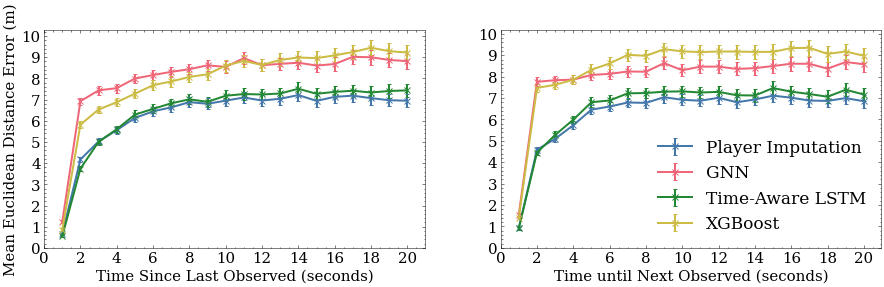

In [12]:
fig_observation = ep.create_error_across_observation_time_plot(agent_imputer,lstm_results,gnn_results,xgboost_results)

## Experiment 3: Distance Error over Time
Gets the distance error over time and see how error changes through game periods. Performs t-tests to validate results.

#### Plot error over period

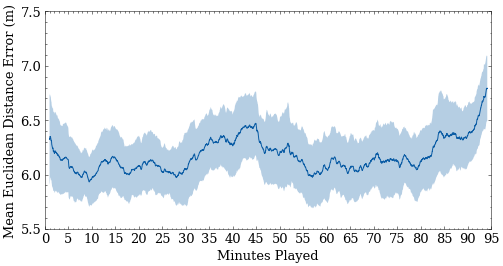

In [13]:
agent_imputer_all = pd.concat([agent_imputer_train,agent_imputer],axis=0)

#Split distances for each time, then get rolling average over a game for each second (5 minute rolling average)
event_time_dist=agent_imputer_all.groupby('event_time').mean()[['match_id','dist']]
match_ids = np.array(agent_imputer_all['match_id'].unique())
means_time_df = ut.get_rolling_average_error(event_time_dist,match_ids)
fig_periods = ep.plot_error_over_game_periods(means_time_df)

#### T-tests for middle and end of halves

In [14]:
#Get error for different periods
etd = event_time_dist.copy()
etd.index = etd.index/60
etd_midfirst = etd[(etd.index > 20) & (etd.index < 25)]['dist']
etd_endfirst = etd[(etd.index > 42.5) & (etd.index < 47.5)]['dist'].sample(len(etd_midfirst))
etd_midsecond = etd[(etd.index > 65) & (etd.index < 70)]['dist']
etd_endsecond = etd[(etd.index > 87.5) & (etd.index < 92.5)]['dist'].sample(len(etd_midsecond))

print("T-test for first half: ", scipy.stats.ttest_rel(etd_midfirst, etd_endfirst, alternative='less'))
print("T-test for second half: ", scipy.stats.ttest_rel(etd_midsecond, etd_endsecond, alternative='less'))

T-test for first half:  Ttest_relResult(statistic=-5.659612253060507, pvalue=8.132334857557865e-09)
T-test for second half:  Ttest_relResult(statistic=-8.819685353127799, pvalue=1.0148838746519146e-18)


# Downstream Applications

## Application 1: Distance Covered
Gets distance for each player, try and get actual distances from tracking data

In [15]:
agent_imputer_dist_covered = agent_imputer.copy()

In [16]:
dist_df = ut.distance_covered_metric(agent_imputer_dist_covered, True)
dist_df_by_position = dist_df.groupby('position').mean()
print("Average distance covered (m) per position: ")
dist_df_by_position

Average distance covered (m) per position: 


,player,match,mins,pred_dist,act_dist,error,dist_per_90,dist_act_per_90,err_p_90
position,,,,,,,,,
Center Back,155468.777778,42936.000000,73.535818,6501.297229,6643.041105,5.139648,7917.391107,8091.830000,5.139648
Center Midfielder,158452.391304,42937.608696,55.713754,5703.682866,5741.804698,3.916661,9341.462460,9433.127566,3.916661
Goalkeeper,102582.666667,42936.000000,76.193217,2674.620987,2653.131951,1.725440,3153.000705,3120.259436,1.725440
Striker,153405.384615,42936.692308,59.713029,5588.587678,5492.805519,6.583242,8435.526040,8414.829108,6.583242
Wing Back,132446.363636,42936.636364,64.610721,6405.472877,6454.594305,5.915321,8951.045311,9090.143995,5.915321
Winger,166757.000000,42937.000000,76.317721,7232.507322,7503.172114,3.956059,8503.829013,8838.925459,3.956059


## Application 2: Pitch Control

In [ ]:
pc_errors_ai = []
pc_errors_lstm = []
pc_errors_xg = []
pc_errors_gnn = []

#Loop through event samples
for e in random.sample(list(agent_imputer['event_id'].unique()), 1):
    #Calculate the pitch control for each model using their predicted positions of players
    print("PITCH CONTROL FOR EVENT: ", e)
    PPCFa_ai, ax = ut.calculate_model_pitch_control(agent_imputer, e, False)
    PPCFa_lstm, ax = ut.calculate_model_pitch_control(lstm_results, e, False)
    PPCFa_xg, ax = ut.calculate_model_pitch_control(xgboost_results, e, False)
    PPCFa_gnn, ax = ut.calculate_model_pitch_control(gnn_results, e, False)
    PPCFa_actual, ax = ut.calculate_model_pitch_control(agent_imputer, e, True)
    
    #Calculate MAE difference between model predictions and actual pitch control
    pc_errors_ai.append(abs(PPCFa_ai-PPCFa_actual).mean())
    pc_errors_lstm.append(abs(PPCFa_lstm-PPCFa_actual).mean())
    pc_errors_xg.append(abs(PPCFa_xg-PPCFa_actual).mean())
    pc_errors_gnn.append(abs(PPCFa_gnn-PPCFa_actual).mean())
    print("MAE AGENT IMPUTER: ", abs(PPCFa_ai-PPCFa_actual).mean())
    print("MAE LSTM: ", abs(PPCFa_lstm-PPCFa_actual).mean())
    print("MAE XG: ", abs(PPCFa_xg-PPCFa_actual).mean())
    print("MAE GNN: ", abs(PPCFa_gnn-PPCFa_actual).mean())

#### Calculate mean errors of each model pitch control

In [18]:
print("MEAN ERROR AGENT IMPUTER: ", np.array(pc_errors_ai).mean())
print("MEAN ERROR LSTM: ", np.array(pc_errors_lstm).mean())
print("MEAN ERROR XGBOOST: ", np.array(pc_errors_xg).mean())
print("MEAN ERROR GNN: ", np.array(pc_errors_gnn).mean())

MEAN ERROR AGENT IMPUTER:  0.12025234153073756
MEAN ERROR LSTM:  0.10553546787498702
MEAN ERROR XGBOOST:  0.09439558590734964
MEAN ERROR GNN:  0.1550572393434884


## Application 3: Player Heatmaps
Show a predicted and actual heatmap for players to show usefulness of applying imputed data to such tasks

In [19]:
print("Unique match and player ids: ")
unique_player_matches = agent_imputer[['player_id','position','match_id']].drop_duplicates().head(5)
unique_player_matches

Unique match and player ids: 


,player_id,position,match_id
0,143591,Goalkeeper,42926
1,188184,Wing Back,42926
2,215548,Center Back,42926
3,215699,Center Back,42926
4,188185,Center Back,42926


C:\Apps\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Apps\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 252x189 with 0 Axes>

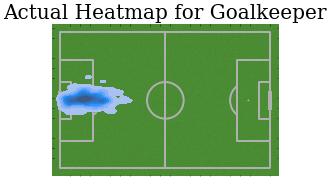

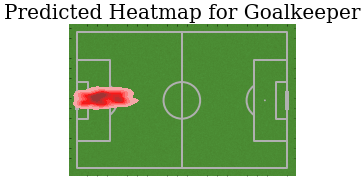

In [20]:
fig1,ax1,fig2,ax2 = ut.get_player_heatmaps(agent_imputer, unique_player_matches.loc[0,'player_id'],unique_player_matches.loc[0,'match_id'], unique_player_matches.loc[0,'position'])

# Other useful plots and visualisations

### Visualisation 1: Plot players

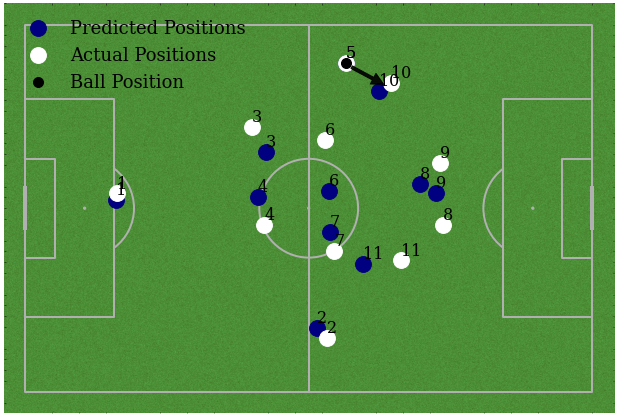

In [21]:
for e in range(69241,69242):
    fig,ax = ut.plot_estimated_players(agent_imputer, e)

### Utility 1: Get Period Changes and do error over time for each half

In [ ]:
agent_imputer_all = pd.concat([agent_imputer_train,agent_imputer],axis=0).reset_index(drop=True)
count = 1
period = []
for i,row in agent_imputer_all.iterrows():
    if i > 0:
        if agent_imputer_all.loc[i,'event_time'] < agent_imputer_all.loc[i-1,'event_time']:
            if agent_imputer_all.loc[i,'event_time'] > 1000:
                count = 2
            else:
                count = 1
    period.append(count)
    
agent_imputer_all['period'] = period
agent_imputer_all

In [23]:
agent_period_1 = agent_imputer_all[agent_imputer_all['period'] == 1]
agent_period_2 = agent_imputer_all[agent_imputer_all['period'] == 2]

### First half graph

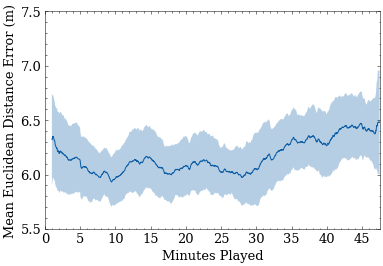

In [24]:
#Split distances for each time, then get rolling average over a game for each second (5 minute rolling average)
event_time_dist_1=agent_period_1.groupby('event_time').mean()[['match_id','dist']]
match_ids = np.array(agent_period_1['match_id'].unique())
means_time_df = ut.get_rolling_average_error_period1(event_time_dist_1,match_ids,1)
fig_periods = ep.plot_error_over_game_periods_period1(means_time_df)

In [25]:
#Get error for different periods
etd = event_time_dist_1.copy()
etd.index = etd.index/60
etd_endfirst = etd[(etd.index > 42.5) & (etd.index < 47.5)]['dist']
etd_midfirst = etd[(etd.index > 20) & (etd.index < 25)]['dist'].sample(len(etd_endfirst))

print("T-test for first half: ", scipy.stats.ttest_rel(etd_midfirst, etd_endfirst, alternative='less'))

T-test for first half:  Ttest_relResult(statistic=-8.201473275400659, pvalue=1.8915707097323477e-16)


### Second half graph

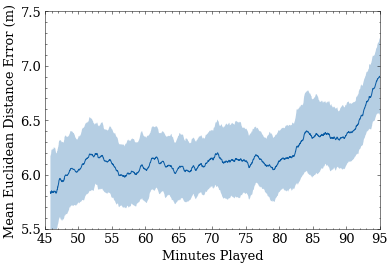

In [26]:
#Split distances for each time, then get rolling average over a game for each second (5 minute rolling average)
event_time_dist_2=agent_period_2.groupby('event_time').mean()[['match_id','dist']]
match_ids = np.array(agent_period_2['match_id'].unique())
means_time_df = ut.get_rolling_average_error_period1(event_time_dist_2,match_ids,2)
fig_periods = ep.plot_error_over_game_periods_period2(means_time_df)

In [27]:
#Get error for different periods
etd = event_time_dist_2.copy()
etd.index = etd.index/60
etd_midsecond = etd[(etd.index > 65) & (etd.index < 70)]['dist']
etd_endsecond = etd[(etd.index > 87.5) & (etd.index < 92.5)]['dist'].sample(len(etd_midsecond))

print("T-test for second half: ", scipy.stats.ttest_rel(etd_midsecond, etd_endsecond, alternative='less'))

T-test for second half:  Ttest_relResult(statistic=-8.637756986267076, pvalue=4.847508892268088e-18)


## Extra Experiment: Error over zones

In [28]:
agent_imputer['cell_index'] = ut._get_flat_indexes(agent_imputer['ballx'],agent_imputer['bally'])
grid_coords = ut.get_grid_points(8,6)[2]

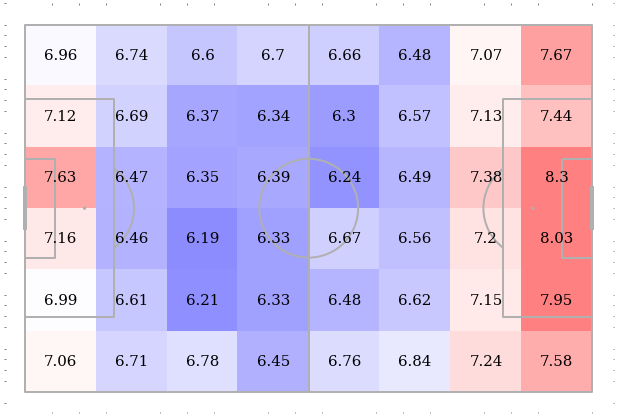

In [29]:
dists = agent_imputer.groupby('cell_index').mean()[['dist']].round(2).values.reshape(6,8)
pitch = Pitch(pitch_type='uefa', pitch_length = 105, pitch_width=68)
fig,ax = pitch.draw()
fig.set_size_inches(12,6)
ax.imshow(dists,vmin=6.1,vmax=7.9,cmap="bwr",extent=(0,105,0,68),alpha=0.5)
for i in range(6):
    for j in range(8):
        count = i*8 + j
        text = plt.text(grid_coords[count][0],grid_coords[count][1], dists[i, j], ha="center", va="center", color="k",size=15)

## Extra Experiment: Player Trajectories

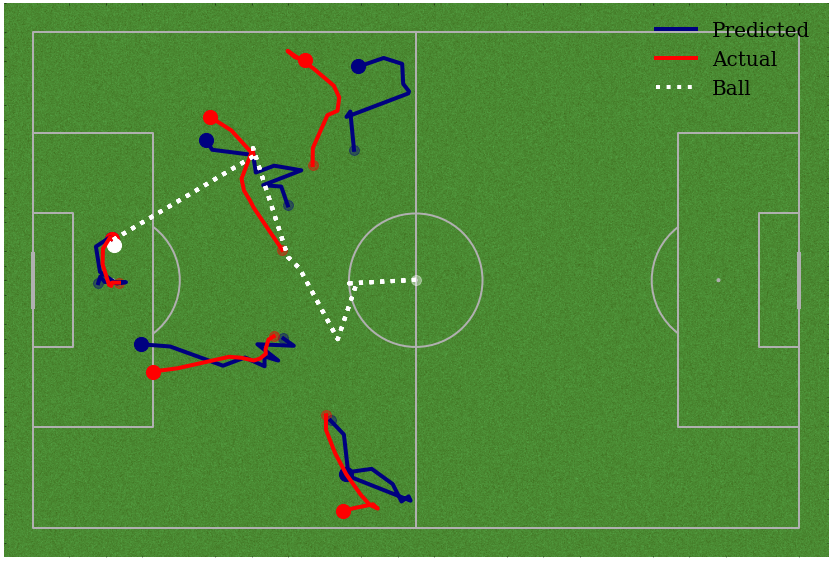

In [30]:
start = 665
end = 675
fig,ax = ep.get_player_trajectories(agent_imputer,start,end,[143591, 188184, 215548, 215699, 215547])